# Import Data

In [4]:
import hickle  as hkl

In [5]:
data2 =hkl.load('./Gen_data/CROSS_Net_input.hkl')

In [9]:
seq_len  = 13   # the length  of  every  sequence

# Prepare Data

In [10]:
import numpy as np

In [129]:
X = data2['seq']
Y = data2['score']

Y_ = [ item[(len(item)-1)/2] for item in Y]
Y_ = np.array(Y_)

X_ = []
for item in X:
    X_.append([singlebite for singlebite in item])




In [130]:
import pandas  as pd
#j将碱基序列转化为数字序列
#d = {'a':1, 'A':1, 'g':2, 'G':2, 'c':3, 'C':3, 't':4, 'T':4, 'N':5, 'n':5}
d = {'a':1.1, 'A':1.1, 'g':3.5, 'G':3.5, 'c':5.6, 'C':5.6, 't':7.9, 'T':7.9, 'N':11, 'n':11}
func = lambda x:d[x]

X_pd = pd.DataFrame(X_ )

X_=X_pd.applymap(func)

X_=X_.values[:,:]
type(X_)


print X_[:3,:]
X_=X_[np.newaxis]
print np.shape(X_)

X_=X_.transpose([1,2,0])
print np.shape(X_)
print X_[:3,:,:]




[[ 3.5  3.5  3.5  1.1  3.5  5.6  5.6  5.6  1.1  3.5  1.1  1.1  3.5]
 [ 3.5  3.5  1.1  3.5  5.6  5.6  5.6  1.1  3.5  1.1  1.1  3.5  3.5]
 [ 3.5  1.1  3.5  5.6  5.6  5.6  1.1  3.5  1.1  1.1  3.5  3.5  5.6]]
(1, 1111101, 13)
(1111101, 13, 1)
[[[ 3.5]
  [ 3.5]
  [ 3.5]
  [ 1.1]
  [ 3.5]
  [ 5.6]
  [ 5.6]
  [ 5.6]
  [ 1.1]
  [ 3.5]
  [ 1.1]
  [ 1.1]
  [ 3.5]]

 [[ 3.5]
  [ 3.5]
  [ 1.1]
  [ 3.5]
  [ 5.6]
  [ 5.6]
  [ 5.6]
  [ 1.1]
  [ 3.5]
  [ 1.1]
  [ 1.1]
  [ 3.5]
  [ 3.5]]

 [[ 3.5]
  [ 1.1]
  [ 3.5]
  [ 5.6]
  [ 5.6]
  [ 5.6]
  [ 1.1]
  [ 3.5]
  [ 1.1]
  [ 1.1]
  [ 3.5]
  [ 3.5]
  [ 5.6]]]


#内存过大 只取一部分
X_ = X_[:60000,:,:]
Y_ = Y_[:60000]

In [121]:
from sklearn.cross_validation import ShuffleSplit
rs = ShuffleSplit(len(Y_), n_iter=1)

In [131]:
for train_idx, test_idx in rs:
    X_train = X_[train_idx,:]
    y_train = Y_[train_idx]
    X_test = X_[test_idx,:]
    y_test = Y_[test_idx]

In [132]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')
print X_train[:2]
print y_train[:2]

[[[ 7.9000001 ]
  [ 3.5       ]
  [ 3.5       ]
  [ 1.10000002]
  [ 3.5       ]
  [ 3.5       ]
  [ 1.10000002]
  [ 3.5       ]
  [ 1.10000002]
  [ 5.5999999 ]
  [ 7.9000001 ]
  [ 3.5       ]
  [ 3.5       ]]

 [[ 7.9000001 ]
  [ 5.5999999 ]
  [ 5.5999999 ]
  [ 5.5999999 ]
  [ 5.5999999 ]
  [ 7.9000001 ]
  [ 1.10000002]
  [ 3.5       ]
  [ 5.5999999 ]
  [ 5.5999999 ]
  [ 3.5       ]
  [ 7.9000001 ]
  [ 3.5       ]]]
[ 0.005 -0.083]


# Generate LSTM Network

In [98]:
import theano
import theano.tensor as T
import lasagne

In [124]:

l_in = lasagne.layers.InputLayer(shape=(None, seq_len, 1)) # raw_seq编码


# Gates of the LSTM
# All gates have initializers for the input-to-gate and hidden state-to-gate
# weight matrices, the cell-to-gate weight vector, the bias vector, and the nonlinearity.
# The convention is that gates use the standard sigmoid nonlinearity,
# which is the default for the Gate class.
gate_parameters = lasagne.layers.recurrent.Gate(
    W_in=lasagne.init.Orthogonal(), W_hid=lasagne.init.Orthogonal(),
    b=lasagne.init.Constant(0.))

cell_parameters = lasagne.layers.recurrent.Gate(
    W_in=lasagne.init.Orthogonal(), W_hid=lasagne.init.Orthogonal(),
    # Setting W_cell to None denotes that no cell connection will be used.
    W_cell=None, b=lasagne.init.Constant(0.),
    # By convention, the cell nonlinearity is tanh in an LSTM.
    nonlinearity=lasagne.nonlinearities.tanh)



# Our LSTM will have 10 hidden/cell units
N_HIDDEN = 20
l_lstm = lasagne.layers.recurrent.LSTMLayer(
    l_in, N_HIDDEN,
    # We need to specify a separate input for masks
    mask_input=None,
    # Here, we supply the gate parameters for each gate
    ingate=gate_parameters, forgetgate=gate_parameters,
    cell=cell_parameters, outgate=gate_parameters,
    # We'll learn the initialization and use gradient clipping
    learn_init=True, grad_clipping=100.)




# The "backwards" layer is the same as the first,
# except that the backwards argument is set to True.
l_lstm_back = lasagne.layers.recurrent.LSTMLayer(
    l_in, N_HIDDEN, ingate=gate_parameters,
    mask_input=None, forgetgate=gate_parameters,
    cell=cell_parameters, outgate=gate_parameters,
    learn_init=True, grad_clipping=100., backwards=True)
# We'll combine the forward and backward layer output by summing.
# Merge layers take in lists of layers to merge as input.
l_sum = lasagne.layers.ElemwiseSumLayer([l_lstm, l_lstm_back])



# First, retrieve symbolic variables for the input shape
n_batch, n_time_steps, n_features = l_in.input_var.shape
# Now, squash the n_batch and n_time_steps dimensions
l_reshape = lasagne.layers.ReshapeLayer(l_sum, (-1, N_HIDDEN))
# Now, we can apply feed-forward layers as usual.
# We want the network to predict a single value, the sum, so we'll use a single unit.
l_dense0 = lasagne.layers.DenseLayer(
    l_reshape, num_units=5, nonlinearity=lasagne.nonlinearities.tanh)
l_dense = lasagne.layers.DenseLayer(
    l_reshape, num_units=1, nonlinearity=lasagne.nonlinearities.tanh)
# Now, the shape will be n_batch*n_timesteps, 1.  We can then reshape to
# n_batch, n_timesteps to get a single value for each timstep from each sequence
l_out = lasagne.layers.ReshapeLayer(l_dense, (n_batch, n_time_steps))

In [125]:
# Symbolic variable for the target network output.
# It will be of shape n_batch, because there's only 1 target value per sequence.
target_values = T.vector('target_output')

# lasagne.layers.get_output produces an expression for the output of the net
network_output = lasagne.layers.get_output(l_out)
# The value we care about is the final value produced for each sequence
# so we simply slice it out.
predicted_values = network_output[:, -1]
# Our cost will be mean-squared error
cost = T.mean((predicted_values - target_values)**2)
# Retrieve all parameters from the network
all_params = lasagne.layers.get_all_params(l_out)
# Compute adam updates for training
updates = lasagne.updates.adam(cost, all_params)
# Theano functions for training and computing cost
train = theano.function(
    [l_in.input_var, target_values ],
    cost, updates=updates)
compute_cost = theano.function(
    [l_in.input_var, target_values], cost)



In [126]:
import random
mylist =range(len(y_train))


In [135]:
# We'll train the network with 10 epochs of 100 minibatches each
NUM_EPOCHS = 200
EPOCH_SIZE = 500
sample_Num = 60000
valid = []
for epoch in range(NUM_EPOCHS): 
    for _ in range(EPOCH_SIZE):      
        random.shuffle(mylist)
        #内存不够，一次不能全部读入所有样本，因此，每次抽取定量样本来训练
        x_banch = X_train[mylist[:sample_Num],:,:]
        y_banch = y_train[mylist[:sample_Num]]
        train(x_banch,y_banch)
    cost_val = compute_cost(X_test, y_test)
    print("Epoch {} validation cost = {}".format(epoch + 1, cost_val))
    valid.append(cost_val)
    if len(valid)>=2:
        if valid[-1]> valid[-2]:
            break 

Epoch 1 validation cost = 0.399080097675
Epoch 2 validation cost = 0.398968487978


KeyboardInterrupt: 

# Test The behave

In [143]:
mylist2 =range(len(y_test))
random.shuffle(mylist2)
x_val = X_test[  mylist2[:10] ,:,:]
y_val = y_test[   mylist2[:10] ]

In [144]:
predict = theano.function( [l_in.input_var],predicted_values)

In [145]:
y_pre = predict(x_val)
for item in range(len(y_val)):
    print y_pre[item],'\t\t',y_val[item]

-0.062764 		-0.499
0.00804754 		-0.342
-0.0146211 		0.289
-0.0187979 		0.0
-0.0509063 		-0.317
-0.0699436 		0.493
0.182129 		0.996
-0.0716128 		0.0
0.162512 		0.0
-0.00345401 		0.054


In [146]:
import matplotlib.pyplot as plt
%matplotlib inline

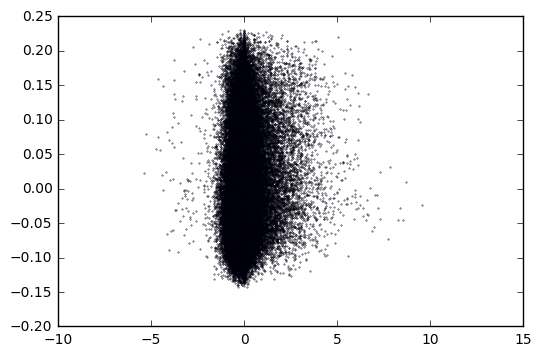

In [147]:
y_pred = predict(X_test)
plt.scatter(y_test,y_pred,0.1)

In [148]:
from scipy import stats

In [149]:
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test,y_pred)
print r_value

0.110682219405


# Save Network Parmas

In [92]:
import pickle
source = './Gen_Data/05_LSTM_Parms.hkl'
params =  l_dense.get_all_params_values()
with open(source,'wb') as f:
    pickle.dump(params,f,-1)

AttributeError: 'DenseLayer' object has no attribute 'get_all_params_values'

# Load Network Params

In [ ]:
import pickle
source = './Gen_Data/05_LSTM_Parms.hkl'
with open(source,'rb') as f:
    params = pickle.load(f)
    l_out.set_all_paralasagnelues(params)